In [45]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


In [41]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [44]:
data = pd.read_csv('../00_source_data/yelp.csv', encoding='latin-1',header=None)
data.columns = ['label','text']
data.head()

,label,text
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [80]:
data['sentiment'] = data['label'].apply(lambda x:'Positive' if x==2 else 'Negative')

In [84]:
sentiment_label = data['sentiment'].factorize()
sentiment_label

(array([0, 1, 0, ..., 1, 1, 1]),
 Index(['Positive', 'Negative'], dtype='object'))

In [105]:
train_x, test_x, train_y, test_y = train_test_split(data['text'], sentiment_label[0], test_size=0.2, random_state=42)

In [108]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
yelp = train_x.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(yelp)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(yelp)
padded_sequence = pad_sequences(encoded_docs, maxlen=20)

In [124]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length,     
                                     input_length=20) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 32)            1849056   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 20, 32)           0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1,865,707
Trainable params: 1,865,707
Non-trainable params: 0
____________________________________________

In [125]:
history = model.fit(padded_sequence,train_y,
                  validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
760/760 [==============================] - 15s 17ms/step - loss: 0.5089 - accuracy: 0.7446 - val_loss: 0.4135 - val_accuracy: 0.8128
Epoch 2/10
760/760 [==============================] - 13s 17ms/step - loss: 0.4008 - accuracy: 0.8198 - val_loss: 0.4047 - val_accuracy: 0.8179
Epoch 3/10
760/760 [==============================] - 13s 17ms/step - loss: 0.3722 - accuracy: 0.8359 - val_loss: 0.4082 - val_accuracy: 0.8184
Epoch 4/10
760/760 [==============================] - 13s 17ms/step - loss: 0.3548 - accuracy: 0.8444 - val_loss: 0.4014 - val_accuracy: 0.8153
Epoch 5/10
760/760 [==============================] - 13s 17ms/step - loss: 0.3374 - accuracy: 0.8545 - val_loss: 0.4033 - val_accuracy: 0.8156
Epoch 6/10
760/760 [==============================] - 13s 17ms/step - loss: 0.3271 - accuracy: 0.8555 - val_loss: 0.4119 - val_accuracy: 0.8171
Epoch 7/10
760/760 [==============================] - 13s 17ms/step - loss: 0.3168 - accuracy: 0.8622 - val_loss: 0.4132 - val_accuracy:

In [126]:
test_pred = tokenizer.texts_to_sequences(test_x.values)
test_pred = pad_sequences(test_pred,maxlen=20)
test_pred = model.predict(test_pred).round()

238/238 [==============================] - 1s 3ms/step


In [127]:
test_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)

In [128]:
test_y

array([1, 1, 1, ..., 0, 1, 1])

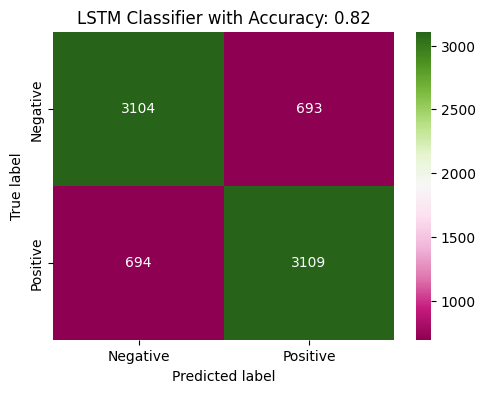

In [129]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
# plot confusion matrix
cm = confusion_matrix(test_y, test_pred)
cm_df = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="PiYG")
plt.title('LSTM Classifier with Accuracy: {0:.2f}'.format(accuracy_score(test_y, test_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# save plot to file
plt.savefig('../30_results/LSTM_real_data.png')

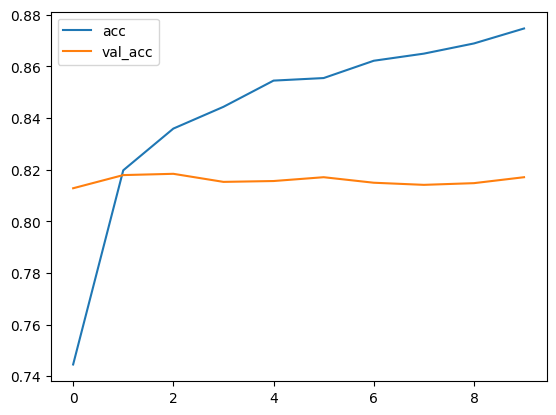

<Figure size 640x480 with 0 Axes>

In [132]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig('../30_results/LSTM_acc.png')

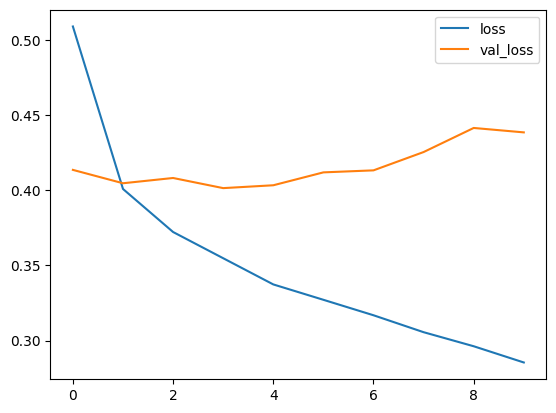

<Figure size 640x480 with 0 Axes>

In [133]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig('../30_results/LSTM_loss.png')